In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import PIL
import scipy
import skimage # 0.16 required

import utils
import utils_camera
import utils_display

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# create configparser to store config

In [2]:
import configparser
config = configparser.ConfigParser()

# Camera configuration

In [3]:
# camera_path = '/run/user/1000/gvfs/mtp:host=%5Busb%3A003%2C003%5D/Mémoire de stockage interne/DCIM/Camera'
camera_path = '.'
camera_config = {'path': camera_path.replace('%', 'PERCENT')}
camera_path = '.'

<IPython.core.display.Javascript object>


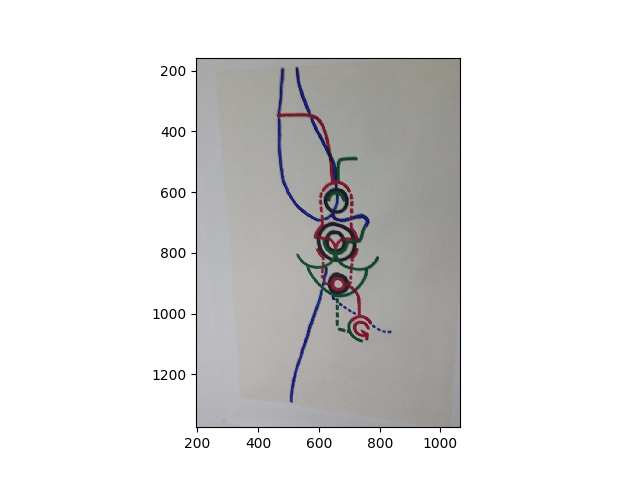

In [4]:
img = utils_camera.get_latest_img(camera_path)
plt.figure()
plt.imshow(img);

# zoom to rectangle in figure above and get coordiantes

In [5]:
axis = plt.gca()
x_min, x_max, y_min, y_max = utils.get_axis_bounds(axis)
camera_config.update({'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})

config['camera'] = camera_config

# Stroke configuration

## zoom to the right part of the image

<IPython.core.display.Javascript object>


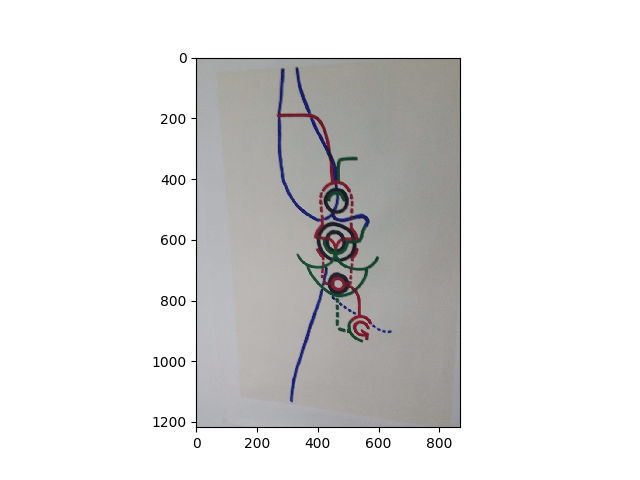

In [6]:
# NOTA: x asix it the second axis
img_np = img[y_min:y_max+1, x_min:x_max+1]
plt.figure()
plt.imshow(img_np);

# Define the colors and plot distance histograms

<IPython.core.display.Javascript object>


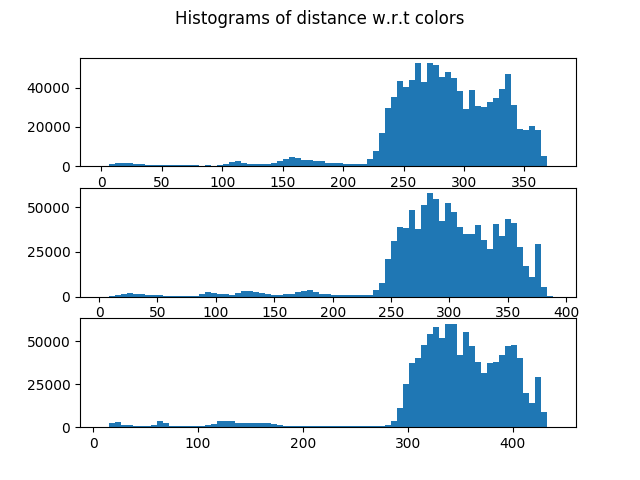

In [7]:
red = np.array([130, 25, 50]).reshape((1,1,3));
blue = np.array([30, 30, 130]).reshape((1,1,3));
green = np.array([20, 80, 40]).reshape((1,1,3));

strokes_config = {
    'red': str(red.reshape(-1).tolist()),
    'blue': str(blue.reshape(-1).tolist()),
    'green': str(green.reshape(-1).tolist())
}

colors = [red, blue, green]

utils.plot_color_distance_histograms(img_np, colors, bins=75)


# define appropriate distance thresholds to separate color

<IPython.core.display.Javascript object>


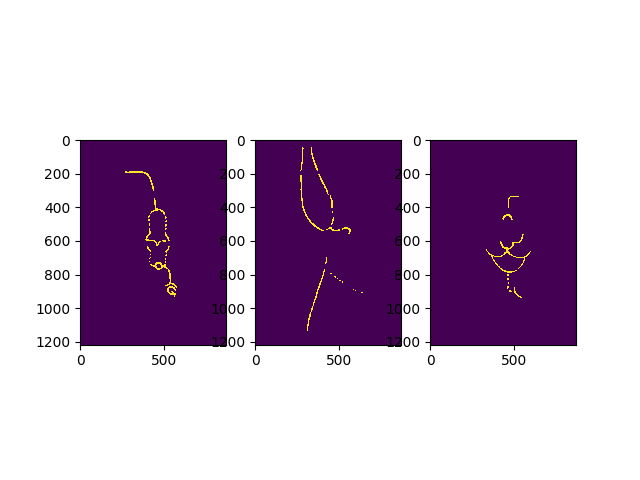

In [8]:
red_threshold = 75
blue_threshold = 80
green_threshold = 50
thresholds = [red_threshold, blue_threshold, green_threshold]

strokes_config.update({'red_threshold': red_threshold, 'blue_threshold': blue_threshold, 'green_threshold': green_threshold})            
red_img, blue_img, green_img = utils.separate_color_images(img_np, colors, thresholds)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)
ax2.imshow(blue_img)
ax3.imshow(green_img);

## get strokes

<IPython.core.display.Javascript object>


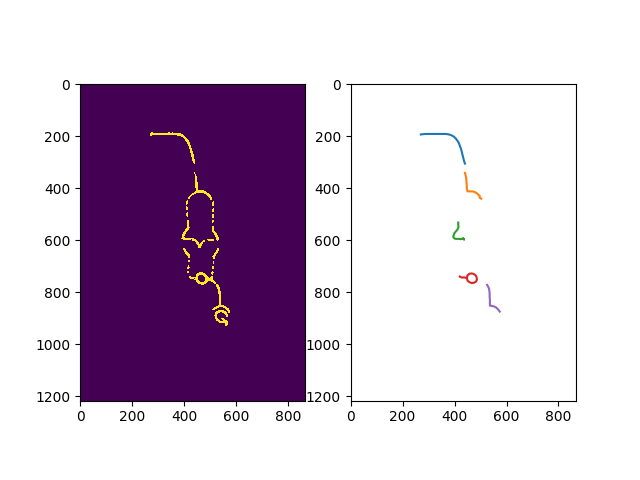

In [9]:
subsample = 8
min_length = 6
strokes_config.update({'subsample': subsample, 'min_length': min_length})
red_strokes = utils.get_strokes(red_img, min_length=min_length, subsample=subsample)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(red_img)

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for stroke in red_strokes:
    stroke = np.array(stroke)
    ax2.plot(stroke[:,1], stroke[:,0])

## save strokes config

In [10]:
config['strokes'] = strokes_config

# Select one stroke and complete it

theta: 5.09


<IPython.core.display.Javascript object>


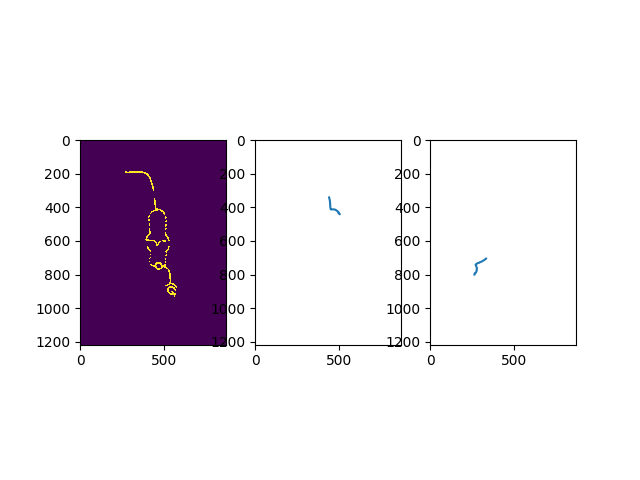

In [11]:
from sketchRNN.sketch_rnn import HParams
import torch
from sketchRNN.complete_img import tina_et_charlie_2

replay_tina_and_charlie_stroke = True

def periodize_stroke(stroke, xlim, ylim):
    # NOT WORKING, periodize the figure
    periodized_stroke = np.zeros_like(stroke)
    periodized_stroke[:,0] = ylim[0] + (stroke[:, 0] - ylim[0]) % (ylim[1] - ylim[0])
    periodized_stroke[:,1] = xlim[0] + (stroke[:, 1] - xlim[0]) % (xlim[1] - xlim[0])
    return periodized_stroke
    
stroke = np.array(red_strokes[np.random.randint(len(red_strokes))])

use_cuda = torch.cuda.is_available()
model_name = 'broccoli_car_cat_20000'
# model_name = 'sketchrnn_ant.full_20000'
# model_name = 'sketchrnn_asparagus.full_40000'
nbr_point_next = 20
sigma = 0.1 

hp_filepath = 'sketchRNN/draw_models/hp_folder/{}.pickle'.format(model_name)
encoder_ckpt = 'sketchRNN/draw_models/encoder_{}.pth'.format(model_name)
decoder_ckpt = 'sketchRNN/draw_models/decoder_{}.pth'.format(model_name)

set_first_point_to_zero = False
rescale_tail = False
stroke_periodized = False

sketchRNN_config = {
    'hp_filepath': hp_filepath,
    'encoder_ckpt': encoder_ckpt,
    'decoder_ckpt': decoder_ckpt,
    'nbr_point_next': nbr_point_next,
    'sigma': sigma,
    'set_first_point_to_zero': set_first_point_to_zero,
    'rescale_tail': rescale_tail,
}



if replay_tina_and_charlie_stroke:
    new_strokes = [utils.translate_and_rotate_stroke(stroke, img_np.shape)]
else:
    paint = [stroke]
    new_strokes = tina_et_charlie_2(hp_filepath, encoder_ckpt, decoder_ckpt, use_cuda,
                                nbr_point_next, paint, paint, sigma,
                                set_first_point_to_zero=set_first_point_to_zero,
                                rescale_tail=rescale_tail)



fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
aspect = ax1.get_aspect()

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
ax2.plot(stroke[:,1], stroke[:,0]);

ax3.set_xlim(ax1.get_xlim());
ax3.set_ylim(ax1.get_ylim());
ax3.set_aspect(ax1.get_aspect());

for new_stroke in new_strokes:
    ax3.plot(new_stroke[:,1], new_stroke[:,0]);

## define interpolation

<IPython.core.display.Javascript object>


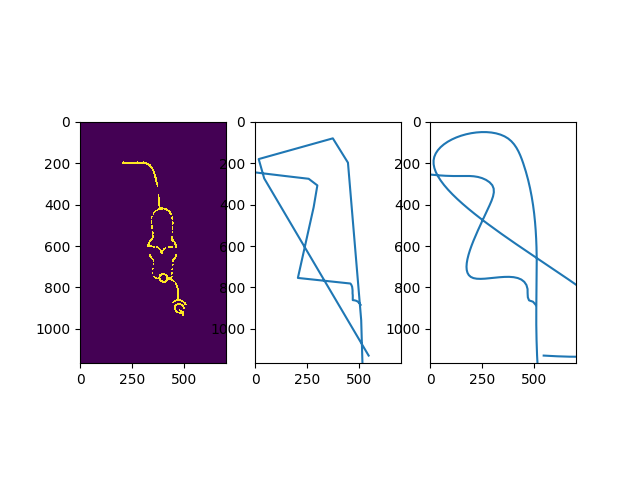

In [12]:
spline_order = 2
n_points_interpolation = 400
interpolated_new_strokes = [
    utils.interpolate_stroke(new_stroke, spline_order=spline_order, n_points=n_points_interpolation) for new_stroke in new_strokes]

sketchRNN_config.update({'spline_order': spline_order, 'n_points_interpolation': n_points_interpolation})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
aspect = ax1.get_aspect()

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for new_stroke in new_strokes:
    ax2.plot(new_stroke[:,1], new_stroke[:,0]);

ax3.set_xlim(ax1.get_xlim());
ax3.set_ylim(ax1.get_ylim());
ax3.set_aspect(ax1.get_aspect());
for interpolated_new_stroke in interpolated_new_strokes:
    ax3.plot(interpolated_new_stroke[:,1], interpolated_new_stroke[:,0]);
    

## save sketchRNN config

In [13]:
config['sketchRNN'] = sketchRNN_config

# display config

<IPython.core.display.Javascript object>


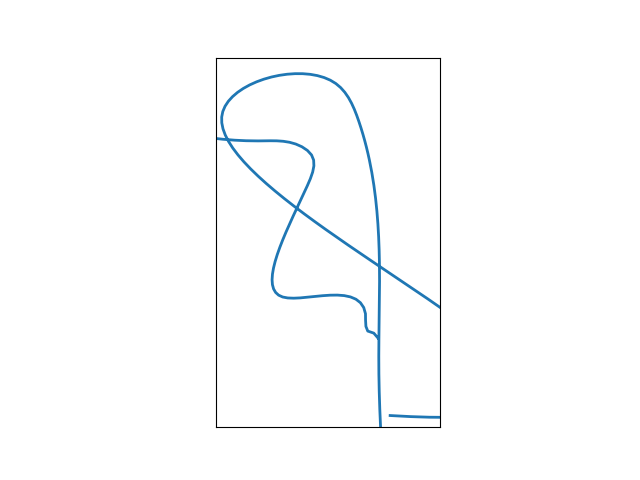

In [15]:
screen_width, screen_height = 1600, 900
image_x, image_y = (233, 177)
image_x_end, image_y_end = (565, 738)
image_width, image_height = image_x_end - image_x , image_y_end - image_y
stroke_width = 2.

display_config = {
    'screen_width': screen_width,
    'screen_height': screen_height,
    'image_x': image_x,
    'image_y': image_y,
    'image_width': image_width,
    'image_height': image_height,
    'stroke_width': stroke_width,
}

utils_display.save_stroke_image(interpolated_new_strokes, xlim, ylim, aspect, screen_height, screen_width, image_y, image_x, image_height, image_width, stroke_width)
utils_display.display_stroke()

## save display config

In [24]:
    config['display'] = display_config

## Save the configfile

In [25]:
config_filename = 'config_example.ini'
with open(config_filename, 'w') as configfile:
    config.write(configfile)